In [34]:
from src.utils.data_utils import *
from src.utils.plot_utils import *
from src.utils.general_utils import *
from src.utils.train_utils import *
from src.data.some_dataloader import RedditDataset

In [35]:
dataset = RedditDataset()
data = dataset.data
body = dataset.data_body
title = dataset.data_title

## A first glance at the data
Here we start by plotting some general statistics about the reddit dataset.
 - The distribution of the number of appareances of each subreddit as source/target. A log-log plot as it is heavy tailed. We have globally more source subreddits than target subreddits. Most subreddits appear onnly a few time in the dataset, some outliers.
 - The Most negative subreddits
 - The Most positive subreddits

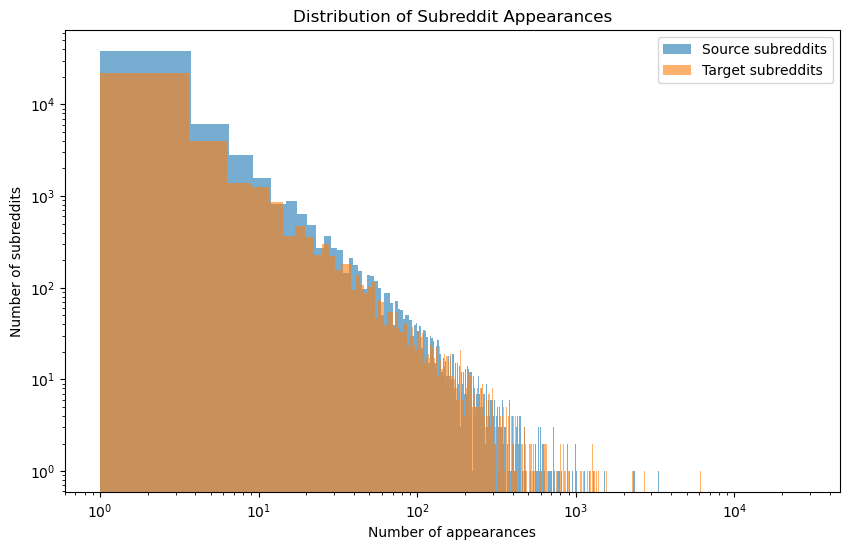

In [36]:
plot_distribution_nb_appearance_subreddits(data)

Using 272 subreddits (>400 posts)


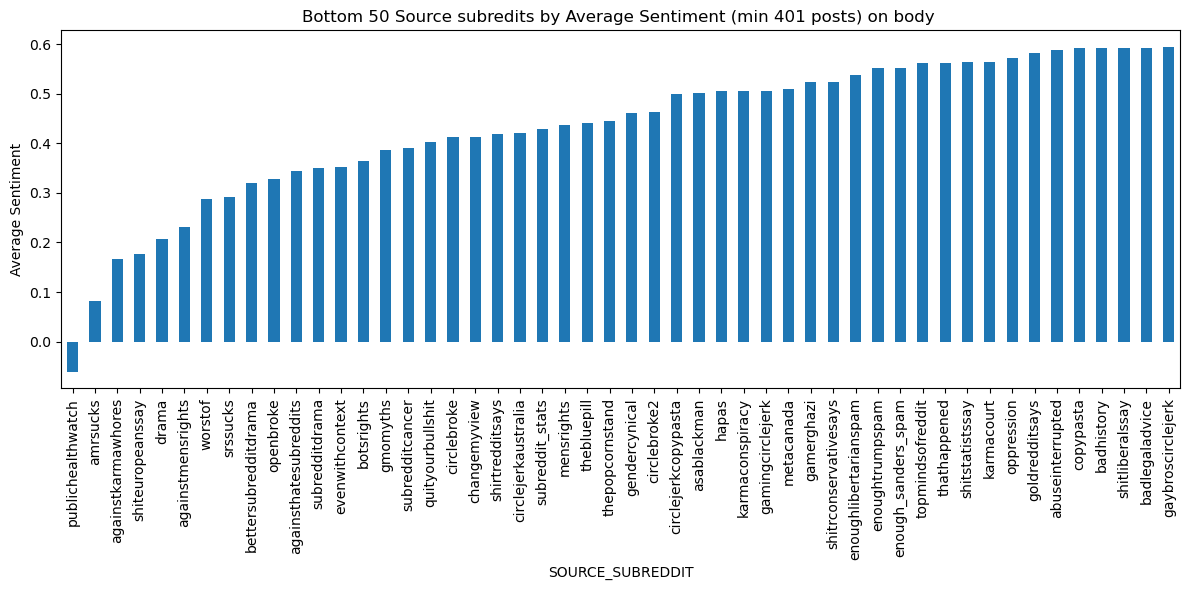

Using 272 subreddits (>400 posts)


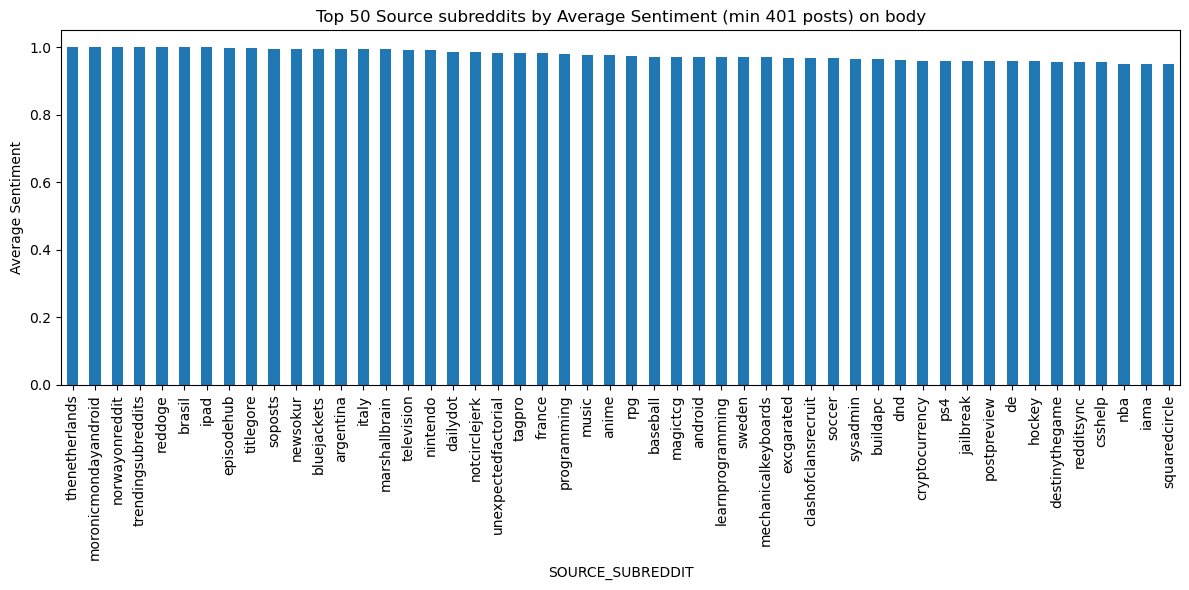

In [37]:
plot_sorted_subreddits(
    get_sorted_subreddits_by_avg_sentiment(data, 'SOURCE_SUBREDDIT',min_count=400, ascending=True),
    50,
    'SOURCE_SUBREDDIT',
    'Bottom 50 Source subredits by Average Sentiment (min 401 posts) on body '
    )

plot_sorted_subreddits(
    get_sorted_subreddits_by_avg_sentiment(data, 'SOURCE_SUBREDDIT',min_count=400 ,ascending=False),
    50,
    'SOURCE_SUBREDDIT',
    'Top 50 Source subreddits by Average Sentiment (min 401 posts) on body'
    )

## Global Time analysis
To investigate our first idea of seeking changing trends towards/against negativity on reddit. 
 - Average Link sentiment per month on 3 years

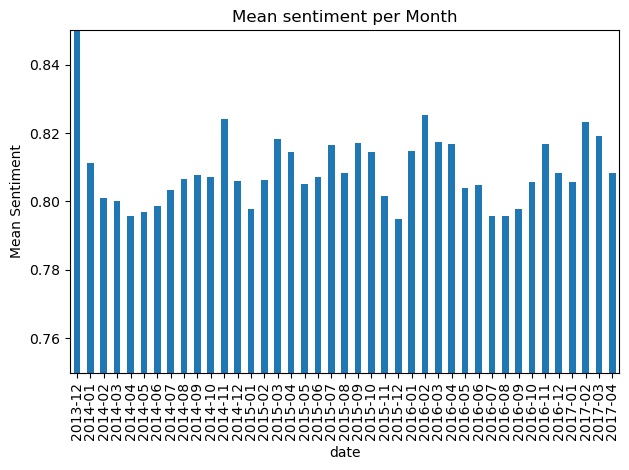

In [38]:
plot_mean_sentiment_per_month(data) ###########PROBLEM D'IMPORT DE PLOT UTILS ICI

A logistic regression model to classify link sentiment over a time window was implemented. This can be a helpful tool to observe a change in importance in a certain properties over time by training models over different time period. 
Here it is demonstrated for a training using the following properties :
 * 5 : Fraction of uppercase characters
 * 10 : Number of long words (at least 6 characters)
 * 15 :  Number of long sentences (at least 10 words)
 * 20 :  Negative sentiment calculated by VADER

In [45]:
properties_test = [5, 10, 15, 20] # properties we want the logistic regression to be trained on, this is just an example
path_test = 'src/models/properties_logitreg_test.pkl' 
train_logit_link_sentiment_timewindow(data, properties_test, path_test, '2016-01-01', '2017-01-01') # over 2016

Model saved to src/models/properties_logitreg_test.pkl
                           Logit Regression Results                           
Dep. Variable:         LINK_SENTIMENT   No. Observations:                  541
Model:                          Logit   Df Residuals:                      536
Method:                           MLE   Df Model:                            4
Date:                Tue, 04 Nov 2025   Pseudo R-squ.:                 0.01513
Time:                        14:51:39   Log-Likelihood:                -125.07
converged:                       True   LL-Null:                       -126.99
Covariance Type:            nonrobust   LLR p-value:                    0.4276
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5996      0.305      8.512      0.000       2.001       3.198
prop_5         0.1003      2.094      0.048      0.962      -4.003       4.2

# Reddit as a graph srtucture
TO COMPLETE 

html spring graph of 2 most negative outgoing subreddits

In [ ]:
write_html_spring_graph_n_nodes(
    body,
    get_sorted_subreddits_by_avg_sentiment(body, direction='SOURCE_SUBREDDIT',min_count=400, ascending=True),
    2
    )

Using 71 subreddits (>400 posts)
